In [1]:
import os
import warnings
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Packages for modelling
import tensorflow as tf
import keras.backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


# Data Preprocessing

In [2]:
df = joblib.load("../data/df_final_v3.gzip")
df["date"] = pd.to_datetime(df["date"])
df = df[["date", "clean_tweet"]]
df = df.groupby("date")["clean_tweet"].agg(sum)
df.head()

date
2017-01-01    Happy New Year, everyone! Like atUser just tol...
2017-01-03    New Glaeser paper on real estate bubbles sugge...
2017-01-04    China leading financial reformer Peoples Bank ...
2017-01-05    Zhou Xiaochuan: Life for dogs !! - Sign the Pe...
2017-01-06    bis Haruhiko Kuroda: A new phase of the global...
Name: clean_tweet, dtype: object

In [3]:
fx = pd.read_csv("../data/Currency_Data_GBPUSD.csv", index_col=False)
fx.columns = ["currecny", "date", "Open", "High", "Low", "Close"]
fx["date"] = pd.to_datetime(fx["date"])
fx.sort_values(by='date', inplace=True)
fx.reset_index(drop=True, inplace=True)
fx["label"] = fx["Close"].diff(periods=1)
fx.dropna(inplace=True)
fx.drop("currecny", axis=1, inplace=True)
fx["label"] = fx["label"].map(lambda x: 1 if float(x)>=0 else 0)
fx.head()

,date,Open,High,Low,Close,label
1,2007-01-10,2.0434,2.0446,2.0370,2.0418,1
2,2007-01-11,2.0797,2.0874,2.0755,2.0801,1
3,2007-02-08,2.0324,2.0378,2.0282,2.0374,0
4,2007-02-11,2.0801,2.0898,2.0767,2.0894,1
5,2007-03-08,2.0374,2.0461,2.0339,2.0406,0


In [4]:
tweet_and_fx = pd.merge(df, fx, on=["date"])
tweet_and_fx.set_index('date', inplace=True)
print(tweet_and_fx.index.min())
print(tweet_and_fx.index.max())
del df, fx

2017-01-03 00:00:00
2020-06-03 00:00:00


In [5]:
tweet_and_fx = tweet_and_fx[["clean_tweet", "label"]]
tweet_and_fx.columns = ["content", "label"]
tweet_and_fx.head()

,content,label
date,,
2017-01-03,New Glaeser paper on real estate bubbles sugge...,0
2017-01-06,bis Haruhiko Kuroda: A new phase of the global...,1
2017-01-13,Zhou Xiaochuan: Life for dogs !! - Sign the Pe...,0
2017-01-19,"Interview with Haruhiko Kuroda, Governor of th...",0
2017-01-20,Haruhiko Kuroda of BoJ discusses Japans growth...,1


# Word Embedding

In [6]:
# Hyperparameters setting
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 64
VALIDATION_SPLIT = 0.2
GLOVE_DIR = r"F:\embedding_file"
EMBEDDING_DIM = 300
EPOCHS = 100
BATCH_SIZE = 128

In [7]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(tweet_and_fx.content)
sequences = tokenizer.texts_to_sequences(tweet_and_fx.content)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(tweet_and_fx.label))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
indices = np.arange(data.shape[0])
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

C:\Users\YangWang\AppData\Roaming\Python\Python37\site-packages\keras_preprocessing\text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 119323 unique tokens.
Shape of data tensor: (737, 64)
Shape of label tensor: (737, 2)


In [8]:
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.42B.300d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1917494 word vectors.


In [9]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [10]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Modelling

In [11]:
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [12]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 3, padding="same", activation='relu')(embedded_sequences)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(128, 4, padding="same", activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(128, 5, padding="same", activation='relu')(x)
x = MaxPooling1D(16)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[get_f1])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Let the rob hit the road!
history = model.fit(
    x_train, y_train, validation_data=(x_val, y_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, reduce_lr])

Train on 590 samples, validate on 147 samples
Epoch 1/100
590/590 [==============================] - 2s 3ms/step - loss: 0.7718 - get_f1: 0.4964 - val_loss: 0.7301 - val_get_f1: 0.4439
Epoch 2/100
590/590 [==============================] - 0s 46us/step - loss: 0.6912 - get_f1: 0.5074 - val_loss: 0.6886 - val_get_f1: 0.5629
Epoch 3/100
590/590 [==============================] - 0s 48us/step - loss: 0.6759 - get_f1: 0.5021 - val_loss: 0.7190 - val_get_f1: 0.4439
Epoch 4/100
590/590 [==============================] - 0s 50us/step - loss: 0.6503 - get_f1: 0.7296 - val_loss: 0.6929 - val_get_f1: 0.5249
Epoch 5/100
590/590 [==============================] - 0s 48us/step - loss: 0.6121 - get_f1: 0.8592 - val_loss: 0.7272 - val_get_f1: 0.4439
Epoch 6/100
590/590 [==============================] - 0s 48us/step - loss: 0.5710 - get_f1: 0.8228 - val_loss: 0.6925 - val_get_f1: 0.5853
Epoch 7/100
590/590 [==============================] - 0s 45us/step - loss: 0.5054 - get_f1: 0.9474 - val_loss: 0.7

In [13]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 64, 300)           35797200  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 128)           115328    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 128)           65664     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 16, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 16, 128)           8204

In [14]:
def plot_history(history):
    plt.style.use('ggplot')
    # plot results
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f1 = history.history['get_f1']
    val_f1 = history.history['val_get_f1']

    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.title('Loss')
    epochs = len(loss)
    plt.plot(range(epochs), loss, marker='.', label='loss')
    plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
    plt.legend(loc='best')
    ax = plt.gca()
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['top'].set_linewidth(5)
    ax.spines['right'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.set_facecolor('snow')
    plt.grid(color='lightgray', linestyle='-', linewidth=1)
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.subplot(2, 1, 2)
    plt.title('F1 Score')
    plt.plot(range(epochs), f1, marker='.', label='f1')
    plt.plot(range(epochs), val_f1, marker='.', label='val_f1')
    plt.legend(loc='best')
    ax = plt.gca()
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['top'].set_linewidth(5)
    ax.spines['right'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.set_facecolor('snow')
    plt.grid(color='lightgray', linestyle='-', linewidth=1)
    plt.xlabel('epoch')
    plt.ylabel('f1')
    plt.show()

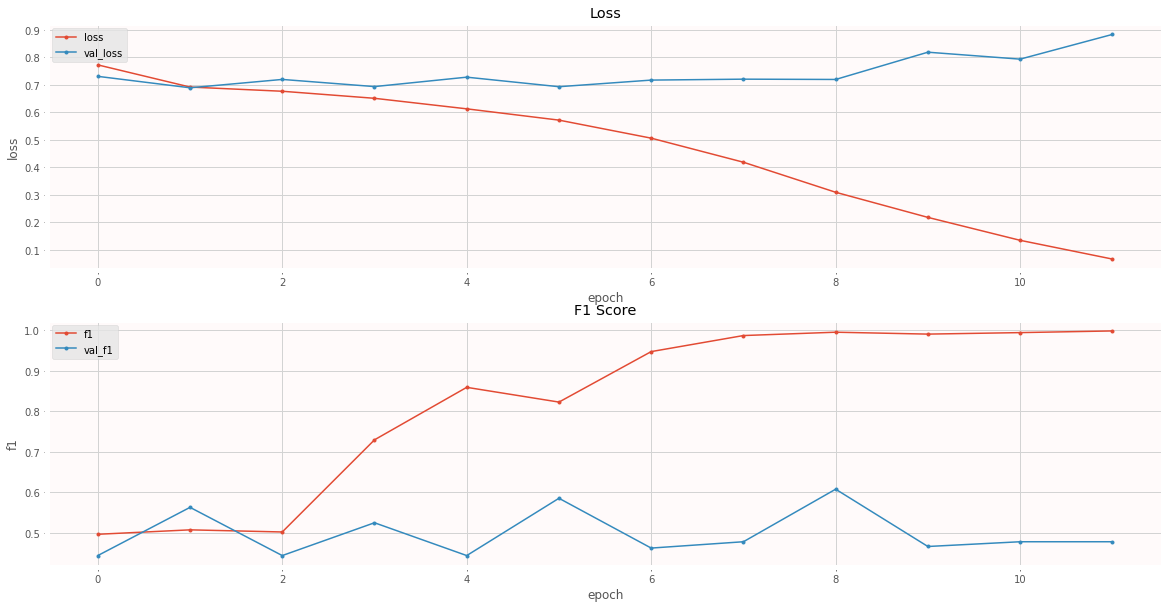

In [15]:
plot_history(history)